In [26]:
print('This notebook was prepared using:')

import os
import sys
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import math
from math import isnan

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import re
import sys
import argparse
import scipy as sp
import random

from scipy import integrate
import scipy.interpolate as sp_interpolate
import statistics

from dataclasses import dataclass
import time as time_module

import simulation as sim
import importlib

# GitHub directories
HIV_DIR = 'data/HIV'
MPL_DIR = 'src/MPL'
SIM_DIR = 'data/simulation'
FIG_DIR = 'figures'

This notebook was prepared using:
python version 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
numpy version 1.24.2
pandas version 1.5.3
matplotlib version 3.7.1


In [3]:
### parameter
importlib.reload(sim)

generations = 500
fn = np.zeros(generations+1)
fi = np.zeros(generations+1)

for t in range(len(fn)):
    fi[t] = 0.04 - 0.08/generations * t
    fn[t] = 0.1  - 0.05/generations * t

pdata = {  
    'NUC':           ['A', 'T'],      # all possible alleles
    'xfile':         '0',             # output file name
    'seq_length':    20,              # sequence length
    'pop_size':      1000,            # population size
    'generations':   generations,     # number of total generations
    'totalT':        500,             # generations used to infer
    'mut_rate':      1e-3,            # mutation rate
    'rec_rate':      1e-3,            # recombination rate
    'inital_state':  4,               # number of initial sub-population
    'n_ben':         4,               # number of beneficial mutations
    'n_del':         4,               # number of deleterious mutations
    's_ben':         0.02,            # selection coefficient of beneficial mutations
    's_del':         -0.02,           # selection coefficient of deleterious mutations
    'fi':            fi,              # time-varying selection coefficient for individual site
    'fn':            fn,              # time-varying selection coefficient for binary trait
    'escape_group':  [[12,15,17]],    # escape sites
    'escape_TF':     [[0,0,0]],       # wild type sequences for escape sites
    'trait_dis':     [[3,2]],         # distance between trait sites
    'p_sites':       [13,18],         # special sites (not escape sites but still time-varying)
    'x_thresh':      -0.05,           # threshold for single allele frequency
    'gamma_s':       10,              # regularization - selection coefficients - constant part
    'gamma_2c':      1000000,         # regularization - the time derivative of the selection coefficients
    'gamma_2tv':     500,             # regularization - the time derivative of the selection coefficients
    'IF_raw':        True,            # True, using raw data; false, using finite sample noise
    }

In [22]:
import numpy as np
totalT = 500
t_step = 1
sample_times    = np.linspace(0,totalT,int(totalT/t_step)+1)
times        = np.linspace(0,totalT,totalT+1)
print(len(sample_times))
print(len(times))


501
501


In [28]:
name = str(0)+'_ns'+str(10)+'_dt'+str(10)
data_full   = np.load('%s/output/nsdt/c_%s.npz'%(SIM_DIR,name), allow_pickle="True")
sc_full     = data_full['selection']
TimeVaryingSC = [np.average(sc_full[i]) for i in range(20)]
print(TimeVaryingSC)

data_full   = np.load('%s/output_multiple/nsdt/c_%s.npz'%(SIM_DIR,name), allow_pickle="True")
sc_full     = data_full['selection']
TimeVaryingSC = [np.average((sc_full[2*i+1]-sc_full[2*i])) for i in range(20)]
print(TimeVaryingSC)


[0.012097086856996613, 0.012627638848009803, 0.019998566856854447, 0.01590045605643212, 0.004814453715163591, -0.004810329307196423, -0.011685521315266182, 0.0016849984599446035, 0.0004401019265885476, 0.005426608407518101, 0.010266852597288852, 0.0030913650270542247, -0.005454647537296731, -0.00453601377694045, -0.0027472330244909544, 0.005109004725453488, -0.010526816801981722, 0.005120330484832386, -0.008197557298636535, -0.0015792032514844953]
[0.013895322177801995, 0.01473680981537627, 0.025371773838502556, 0.01820157457170792, 0.006302521154012156, -0.0037563908921678553, -0.015467974853638683, 0.0020409053756962853, 0.00021231849436757473, 0.006756937997006085, 0.011949885385538582, 0.0040661016256516, -0.007627580913448715, -0.004479862939170187, -0.003316498479186716, 0.006160583757860087, -0.014283482155217478, 0.006298120789778914, -0.009532937762870666, -0.0020668829798186493]


In [33]:
tag = '700010058-3'
data_full   = np.load('%s/output/c_%s_1.npz'%(HIV_DIR,tag), allow_pickle="True")
sc_full     = data_full['selection']
print(sc_full[-1])

data_full   = np.load('%s/output_try/c_%s_1.npz'%(HIV_DIR,tag), allow_pickle="True")
sc_full     = data_full['selection']
print(sc_full[-1])

[0.10661817 0.10641473 0.10602177 0.10545631 0.10473335 0.10386581
 0.10286453 0.10173824 0.10049358 0.09922401 0.09797635 0.0967521
 0.09555247 0.09437842 0.09323066 0.09210966 0.09101569 0.08994876
 0.08890869 0.08789509 0.08690739 0.08594481 0.08500639 0.084091
 0.08319731 0.08232385 0.08146897 0.08063084 0.0798075  0.07899679
 0.07819644 0.07740398 0.07661682 0.0758322  0.07504723 0.07425885
 0.07346386 0.07265894 0.07184061 0.07100526 0.07014913 0.06926838
 0.068359   0.06741689 0.06643784 0.06541755 0.06440168 0.06341341
 0.06245221 0.06151757 0.06060898 0.05972596 0.05886804 0.05803474
 0.05722564 0.05644029 0.05567828 0.0549392  0.05422267 0.05352829
 0.05285571 0.05220457 0.05157452 0.05096524 0.0503764  0.04980771
 0.04925885 0.04872954 0.04821951 0.0477285  0.04725625 0.04680252
 0.04636708 0.0459497  0.04555018 0.0451683  0.04480389 0.04445675
 0.04412671 0.04381362 0.04351731 0.04323765 0.04297449 0.04272772
 0.04249722 0.04228288]
[0.10661817 0.10641473 0.10602177 0.10545

In [2]:
def read_file_special(name):
    result = []

    with open('%s.dat'%name, 'r') as file:
        for line in file:
            line_data = []
            for item in line.split():
                if '/' in item:
                    sub_items = list(map(int, item.split('/')))
                    line_data.append(sub_items)
                else:
                    line_data.append([int(item)])
            result.append(line_data)

    return result

def read_file(name):
    result = []
    with open('%s.dat'%name, 'r') as file:
        for line in file:
            line_data = []
            for item in line.split():
                line_data.append(int(item))
            result.append(line_data)
    return result

a = read_file('b')
print(a)

[[1, 1, 1, 4], [2, 4, 4], [3, 2, 3, 4, 3]]


In [58]:
infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3','700010077-5',
              '700010470-3','700010470-5','700010607-3','703010131-3','703010131-5','703010159-3',
              '703010256-3','703010256-5','704010042-5','705010162-3','705010162-5','704010042-3',
              '705010185-5','705010198-3','706010164-3','706010164-5'] #

for tag in infer_tags:
    rawdata = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
    times   = rawdata['sample_times']
    escape_group = rawdata['escape_group']
    if len(escape_group)>0:
        print(f'\nCH{tag[-5:]}')
        for t in range(len(times)-1):
            print(f'{int(times[t+1]-times[t])}({int((times[t+1]-times[t])/times[-1]*100)}%)',end='\t')


CH040-3
16(2%)	29(5%)	66(11%)	70(12%)	102(18%)	129(23%)	140(25%)	
CH058-3
8(9%)	37(43%)	40(47%)	
CH077-3
14(8%)	18(11%)	70(44%)	57(35%)	
CH470-3
13(3%)	28(6%)	28(6%)	105(25%)	246(58%)	
CH470-5
13(2%)	28(6%)	28(6%)	105(23%)	246(54%)	34(7%)	
CH607-3
9(42%)	5(23%)	7(33%)	
CH131-3
21(6%)	7(2%)	6(1%)	29(8%)	28(8%)	84(25%)	98(29%)	60(18%)	
CH131-5
21(6%)	7(2%)	6(1%)	29(8%)	28(8%)	84(25%)	98(29%)	60(18%)	
CH159-3
8(2%)	4(1%)	10(3%)	7(2%)	27(8%)	29(9%)	217(71%)	
CH256-3
28(4%)	35(5%)	109(15%)	254(37%)	258(37%)	
CH256-5
28(4%)	35(5%)	109(15%)	254(37%)	258(37%)	
CH162-3
21(4%)	56(12%)	102(23%)	259(59%)	
CH162-5
21(4%)	56(12%)	102(23%)	259(59%)	
CH042-3
21(3%)	39(5%)	112(16%)	252(37%)	252(37%)	
CH185-5
25(37%)	42(62%)	
CH198-3
11(18%)	49(81%)	
CH164-3
14(3%)	14(3%)	42(9%)	113(26%)	251(57%)	

In [ ]:
infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3','700010077-5',
              '700010470-3','700010470-5','700010607-3','703010131-3','703010131-5','703010159-3',
              '703010256-3','703010256-5','704010042-5','705010162-3','705010162-5','704010042-3',
              '705010185-5','705010198-3','706010164-3','706010164-5'] #

for tag in infer_tags:
    rawdata = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
    times   = rawdata['sample_times']
    gap = [int((times[t+1]-times[t])) for t in range(len(times)-1)]
    if np.max(gap)/times[-1] > 0.5:
        times_new = times[:-1]
        gap = [int((times_new[t+1]-times_new[t])) for t in range(len(times_new)-1)]
        gap_ratio = [int(i/times_new[-1]*100) for i in gap]
        print(f'CH{tag[-5:]}:{times_new}, {gap_ratio}')
    else:
        gap_ratio = [int(i/times[-1]*100) for i in gap]
        print(f'CH{tag[-5:]}:{times}, {gap_ratio}')

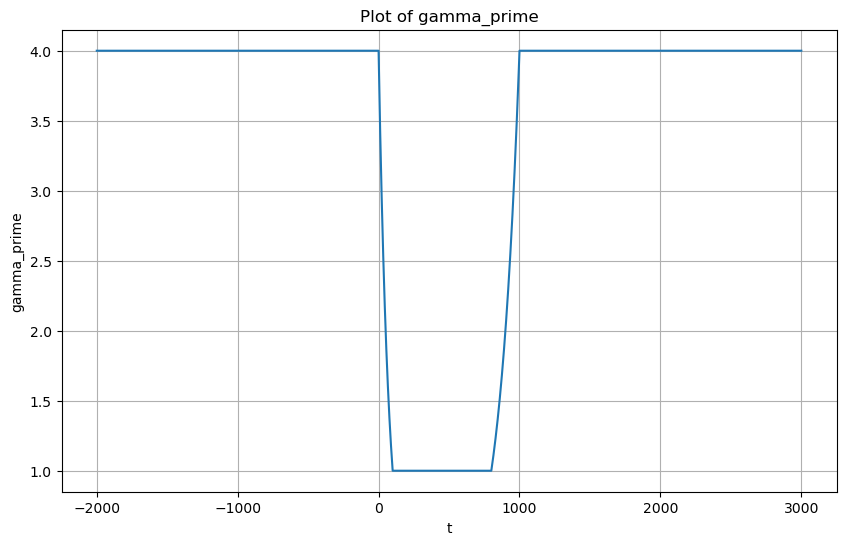

In [196]:
# extend the time range
TLeft   = int(round(times[-1]*2/10)*10) # time range added before the beginning time
TRight  = int(round(times[-1]*2/10)*10) # time range added after the ending time
etleft  = np.linspace(-TLeft,-40,int(TLeft/40)) # time added before the beginning time (dt=10)
etright = np.linspace(times[-1]+40,times[-1]+TRight,int(TRight/40))
ExTimes = np.concatenate((etleft, times, etright))

# individual site: gamma_2c, escape group and special site: gamma_2tv
# gamma 2 is also time varying, it is smaller at the boundary

gamma_t = np.zeros(len(ExTimes))
beta_1 = 4
beta_2 = 4
ratio_1 = 0.1
ratio_2 = 0.2
alpha1  = np.log(beta_1) / (ratio_1*1000)
alpha2  = np.log(beta_2) / (ratio_2*1000)

for t in range(len(ExTimes)):
    if t <= len(etleft):
        gamma_t[t] = beta_1
    elif t >= len(etleft)+len(times):
        gamma_t[t] = beta_2
    elif len(etleft) < t and t < len(etleft)+(len(times)-1)*ratio_1:
        tt = (t - len(etleft)) * 1
        gamma_t[t] = beta_1 * np.exp(-alpha1 * tt)
    elif len(etleft)+(len(times)-1)*(1 - ratio_2) < t and t < len(etleft)+len(times):
        tt = (t - len(etleft)) * 1 - (1 - ratio_2) * totalT
        gamma_t[t] = 1 * np.exp(alpha2 * tt)
    else:
        gamma_t[t] = 1


plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()



In [194]:
const_num = 6
output = '_ll_11'
# Neumann boundary condition
f = open('%s/simple/mpl_collected%s.csv'%(SIM_DIR,output),'w')
f.write('trajectory,ns,delta_t')
for i in range(const_num):
    f.write(',sc_%d'%i)
f.write('\n')

for k in range(100):
    name = str(k)
    data_full   = np.load('%s/simple/output%s/c_%s.npz'%(SIM_DIR,output,name), allow_pickle="True")
    sc_full     = data_full['selection']
    TimeVaryingSC = [np.average(sc_full[i]) for i in range(const_num)]
    f.write('%d,1000,1'%k)
    for i in range(const_num):
        f.write(',%f'%TimeVaryingSC[i])
    f.write('\n')
f.close()

In [189]:
ratio = 0.2
alpha  = np.log(beta) / (ratio*1000)
gamma =  np.exp(alpha * 150)
print(gamma)

2.8284271247461903


In [152]:
print(len(etleft)+len(times))
print(len(ExTimes)-len(etright)-1)

1051
1050


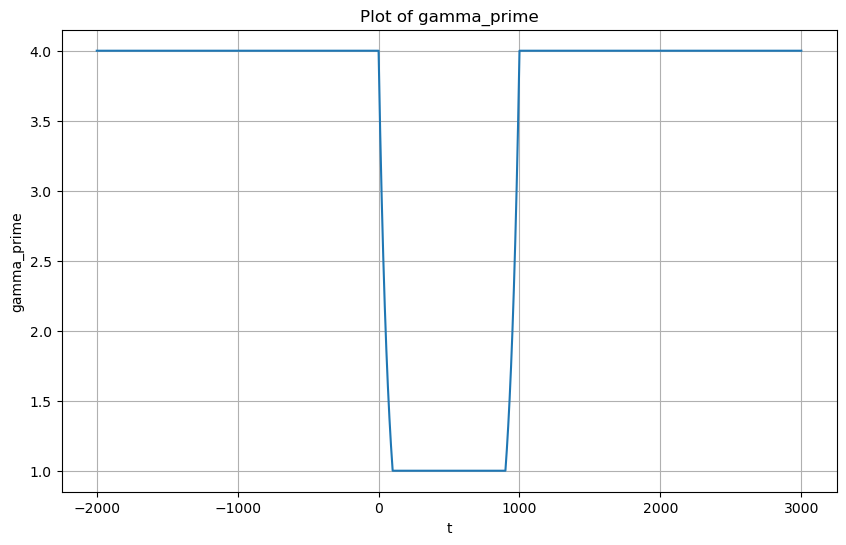

In [147]:
gamma_t = np.zeros(len(ExTimes))
beta = 4
alpha = np.log(beta) / totalT * 10
for tt in range(len(ExTimes)):
    if tt <= len(etleft) or len(ExTimes)-len(etright)-1 < tt:
        gamma_t[tt] = beta
    elif tt > len(etleft) and tt <= len(etleft)+(len(times)-1)/10:
        t = (tt - len(etleft)) * 1
        gamma_t[tt] = beta * np.exp(-alpha * t)
    elif tt > len(etleft)+(len(times)-1)*0.9 and tt < len(etleft)+len(times):
        t = (tt - len(etleft)) * 1 - 0.9*totalT
        gamma_t[tt] = 1 * np.exp(alpha * t)
    else:
        gamma_t[tt] = 1

plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()

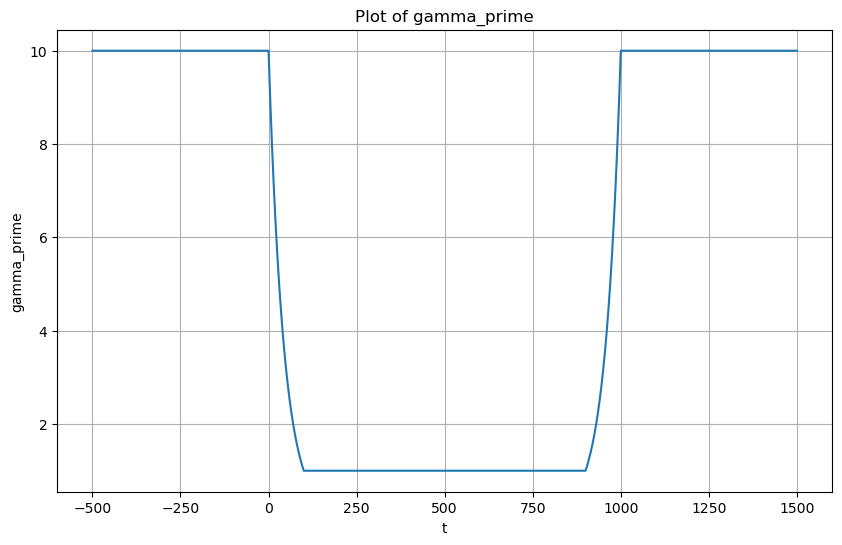

In [136]:
import numpy as np
import matplotlib.pyplot as plt

totalT = 1000
times = np.linspace(0,totalT,totalT+1)

TLeft   = int(round(times[-1]*0.5/10)*10) # time range added before the beginning time
TRight  = int(round(times[-1]*0.5/10)*10) # time range added after the ending time
etleft  = np.linspace(-TLeft,-5,int(TLeft/5)) # time added before the beginning time (dt=10)
etright = np.linspace(times[-1]+5,times[-1]+TRight,int(TRight/5))
ExTimes = np.concatenate((etleft, times, etright))

gamma_t = np.zeros(len(ExTimes))
beta = 10
alpha = np.log(beta) / totalT * 10
for tt in range(len(ExTimes)):
    if tt <= len(etleft) or len(ExTimes)-len(etright)-1 < tt:
        gamma_t[tt] = beta
    elif tt > len(etleft) and tt <= len(etleft)+(len(times)-1)/10:
        t = (tt - len(etleft)) * 1
        gamma_t[tt] = beta * np.exp(-alpha * t)
    elif tt > len(etleft)+(len(times)-1)*0.9 and tt < len(etleft)+len(times):
        t = (tt - len(etleft)) * 1 - 0.9*totalT
        gamma_t[tt] = 1 * np.exp(alpha * t)
    else:
        gamma_t[tt] = 1

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()

In [135]:
import numpy as np

# 示例数组a
a = np.array([1, 2, 3])

# 设定行数
num_rows = 5

# 利用广播创建矩阵b
b = np.vstack([a*2] * num_rows)

print(a)
print(b)


[1 2 3]
[[2 4 6]
 [2 4 6]
 [2 4 6]
 [2 4 6]
 [2 4 6]]


In [123]:
gamma_2[1051]

2.0

In [24]:
import inference_HIV as HIV
importlib.reload(HIV)

tag = '700010077-3'
gamma1 = 1
result       = HIV.AnalyzeData(tag,gamma1)


In [15]:
print(result.escape_TF)

[[3, 1, 2, 1, 4], [1, 3, 2, 3], [3, 3, 1], [1, 3, 1, 4], [3, 1, 4, 3, 1, 2, 3, 2, 1, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 1, 2], [1, 1, 2, 4, 2]]


In [21]:
print(result.escape_TF)

[[[3], [1], [2], [1], [2, 4]], [[1], [3], [2], [3]], [[3], [3], [1]], [[1], [3], [1], [4]], [[3], [1], [4], [3], [1], [2], [3], [2], [1], [3], [4], [1, 3], [3], [3], [3], [3], [4], [3], [3], [3], [1], [2]], [[1], [1], [2], [4], [2]]]


In [42]:
importlib.reload(sim)

# Load the simulation data
data         = np.loadtxt("%s/example/example-0.dat"%(SIM_DIR))
escape_group = sim.read_file('example','traitsite-0.dat')
trait_dis    = sim.read_file('example','traitsite-0.dat')

p_sites      = [13,18]
# Calculate covariance matrix
sVec,nVec,eVec = sim.getSequence(data,escape_group)
seq_length     = len(sVec[0][0])      # sequence length
ne             = len(escape_group) # trait group

muVec    = -np.ones(seq_length)
x_length = 0
for i in range(seq_length):
    allele_count = np.zeros(len(sVec))
    allele_count = [np.sum([(sVec[t][k][i]==1)*nVec[t][k] for k in range(len(sVec[t]))]) for t in range(len(sVec))]
    if max(allele_count) / np.sum(nVec[0]) >= 0:
        muVec[i] = x_length
        x_length += 1
x_length      += ne


In [60]:
def get_allele_frequency(sVec,nVec,eVec,muVec):

    x  = np.zeros((len(nVec),x_length))           # single allele frequency
    xx = np.zeros((len(nVec),x_length,x_length))  # pair allele frequency
    for t in range(len(nVec)):
        pop_size_t = np.sum([nVec[t]])
        # individual locus part
        for i in range(seq_length):
            aa = int(muVec[i])
            if aa != -1:
                x[t,aa] = np.sum([sVec[t][k][i] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for j in range(int(i+1), seq_length):
                bb = int(muVec[j])
                if bb != -1:
                    xx[t,aa,bb] = np.sum([sVec[t][k][i] * sVec[t][k][j] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                    xx[t,aa,bb] = np.sum([sVec[t][k][i] * sVec[t][k][j] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
        # escape part
        for n in range(ne):
            aa      = x_length-ne+n
            x[t,aa] = np.sum([eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for m in range(int(n+1), ne):
                bb          = x_length-ne+m
                xx[t,aa,bb] = np.sum([eVec[t][k][n] * eVec[t][k][m] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                xx[t,bb,aa] = np.sum([eVec[t][k][n] * eVec[t][k][m] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for j in range(seq_length):
                bb = int(muVec[j])
                if bb != -1:
                    xx[t,bb,aa] = np.sum([sVec[t][k][j] * eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                    xx[t,aa,bb] = np.sum([sVec[t][k][j] * eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
    return x,xx

# calculate escape frequency (binary case)
def get_escape_fre_term(sVec,nVec):
    ex  = np.zeros((len(nVec),ne,seq_length))
    for t in range(len(nVec)):
        pop_size_t = np.sum([nVec[t]])
        for k in range(len(sVec[t])):
            for n in range(ne):
                n_mutations = 0
                for nn in escape_group[n]:
                    if sVec[t][k][nn] != 0:
                        n_mutations += 1
                        site = nn
                if n_mutations == 1:
                    ex[t,n,site] += nVec[t][k]
        ex[t,:,:] = ex[t,:,:] / pop_size_t
    return ex

x,xx         = get_allele_frequency(sVec,nVec,eVec,muVec) 
covar_int    = sim.diffusion_matrix_at_t(x,xx,x_length)


In [79]:
gamma_1s      = 10/500 # gamma_s/time points
gamma_1p      = gamma_1s/10
gamma_2c      = 1000000       # 1000000
gamma_2tv     = 500

# regularization value gamma_1 and gamma_2
# individual site: gamma_1s, escape group: gamma_1p
gamma1_m = np.zeros((x_length,x_length))
for i in range(x_length):
    gamma1_m[i][i] = gamma_1s
for n in range(ne):
    nn = x_length-ne+n
    gamma1_m[nn][nn] = gamma_1p

# individual site: gamma_2c, escape group and special site: gamma_2tv
gamma2 = np.ones(x_length)*gamma_2c
for n in range(ne):
    gamma2[x_length-ne+n] = gamma_2tv
for i in range(len(p_sites)): # special site - time varying
    index = int (muVec[p_sites[i]]) 
    if index != -1:
        gamma2[index] = gamma_2tv

A_matrix = np.zeros((x_length,x_length))
for i in range(x_length):
    for j in range(x_length):
        A_matrix[i][j] = (np.average(covar_int[:,i,j])+gamma1_m[i,j])/gamma2[i]

print(A_matrix[0,0])

1.6262595409181634e-07


In [46]:
d_value, Q_matrix = np.linalg.eig(A_matrix) # calculate the eigenvalues d_value and eigenvectors Q_matrix
D_matrix = np.diag(d_value) # D is a diagonal matrix with the eigenvalues of A
